## Term Project - MET CS 777 - Maryam Baizhigitova

# Garbage Detection and Classification System: CNN Model

In [2]:
import json
import cv2
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
import time

## Data Preparation 

In [3]:
# Define the file path where the JSON data is stored
anns_file_path = './data/annotations.json'

# Open the file in read mode and load JSON
with open(anns_file_path, 'r') as f:
    dataset = json.load(f)

In [4]:
# Extract annotations, images, and categories from the file
anns = dataset['annotations']
imgs = dataset['images']
categories = {cat['id']: cat['name'] for cat in dataset['categories']}

In [5]:
# Create a dictionary for images that includes filename, width, and height
images_dict = {img['id']: {'filename': img['file_name'], 'width': img['width'], 'height': img['height']} for img in imgs}

In [6]:
# Create a list to populate with data for the DataFrame
data = []

# Iterate over each annotation
for ann in anns:
    image_id = ann['image_id']
    
    # Check if the image_id exists in images_dict
    if image_id in images_dict:
        img_info = images_dict[image_id]
        
        # Create an entry for the DataFrame
        entry = {
            'image_id': image_id,
            'filename': img_info['filename'],
            'width': img_info['width'],        # Include width
            'height': img_info['height'],      # Include height
            'category_id': ann['category_id'],
            'category': categories[ann['category_id']],
            'bbox_x_min': ann['bbox'][0],
            'bbox_y_min': ann['bbox'][1],
            'bbox_width': ann['bbox'][2],
            'bbox_height': ann['bbox'][3]
        }
        
        # Append the entry to the data list
        data.append(entry)

In [ ]:
# Create a list to populate with data for the DataFrame
data = []
for ann in anns:
    image_id = ann['image_id']
    if image_id in images_dict:  # Check if the image_id exists in images_dict
        img_info = images_dict[image_id]
        entry = {
            'image_id': image_id,
            'filename': img_info['filename'],
            'width': img_info['width'],        # Include width
            'height': img_info['height'],      # Include height
            'category_id': ann['category_id'],
            'category': categories[ann['category_id']],
            'bbox_x_min': ann['bbox'][0],
            'bbox_y_min': ann['bbox'][1],
            'bbox_width': ann['bbox'][2],
            'bbox_height': ann['bbox'][3]
        }
        data.append(entry)

In [7]:
# Create the DataFrame
df = pd.DataFrame(data)
df # Print the first few rows to verify the content

,image_id,filename,width,height,category_id,category,bbox_x_min,bbox_y_min,bbox_width,bbox_height
0,0,batch_1/000006.jpg,1537,2049,6,Glass bottle,517.0000,127.0000,447.0000,1322.0
1,1,batch_1/000008.jpg,1537,2049,18,Meal carton,1.0000,457.0000,1429.0000,1519.0
2,1,batch_1/000008.jpg,1537,2049,14,Other carton,531.0000,292.0000,1006.0000,672.0
3,2,batch_1/000010.jpg,1537,2049,5,Clear plastic bottle,632.0000,987.0000,500.0000,374.0
4,2,batch_1/000010.jpg,1537,2049,7,Plastic bottle cap,632.0000,989.0000,44.0000,51.0
...,...,...,...,...,...,...,...,...,...,...
4779,1498,batch_9/000098.jpg,1824,4000,16,Drink carton,228.7143,1550.0476,1007.9999,579.0
4780,1498,batch_9/000098.jpg,1824,4000,7,Plastic bottle cap,1041.3334,1721.7142,141.0000,138.0
4781,1499,batch_9/000099.jpg,1824,4000,39,Other plastic wrapper,862.0274,1331.2500,505.9726,612.5
4782,1499,batch_9/000099.jpg,1824,4000,14,Other carton,966.0000,1996.0000,211.0000,336.0


In [8]:
# Save this DataFrame to a CSV file for later use
df.to_csv('annotations_df.csv', index=False)

## Data Preprocessing

In [9]:
df = pd.read_csv("annotations_df.csv")
df = df.head(500) # set a subset of the data

In [10]:
image_dir = './data/'
image_size = 416

In [11]:
def preprocess_dataset(df):
    # Lists to store labels, bounding boxes, and images
    labels = []
    boxes = []
    img_list = []
    
    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        # Store label (category_id) for the current row
        labels.append([row['category_id']])
        
        # Scale the bounding box coordinates relative to image dimensions
        scaled_box = [
            row['bbox_x_min'] / row['width'],
            row['bbox_y_min'] / row['height'],
            row['bbox_width'] / row['width'],
            row['bbox_height'] / row['height']
        ]
        boxes.append([scaled_box])
        
        # Load and preprocess the image
        img_path = row['filename']
        img = cv2.imread(os.path.join(image_dir, img_path))
        if img is not None:
            img = cv2.resize(img, (image_size, image_size))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            img = img.astype("float32") / 255.0          # Normalize pixel values
            img_list.append(img)
    
    # Return lists containing labels, boxes, and preprocessed images
    return labels, boxes, img_list

In [12]:
# Call preprocess_dataset to preprocess the DataFrame df
labels, boxes, img_list = preprocess_dataset(df)

# Convert img_list, labels, and boxes to NumPy arrays
img_list = np.array(img_list)
labels = np.array(labels)
boxes = np.array(boxes)

# Create an array of indices from 0 to len(labels) and shuffle them
indices = np.arange(len(labels))
np.random.shuffle(indices)

# Shuffle img_list, labels, and boxes using the shuffled indices
img_list = img_list[indices]
labels = labels[indices]
boxes = boxes[indices]

In [13]:
# Split the data into train and test sets, with 80% for training and 20% for testing
train_images, test_images, train_labels, test_labels, train_boxes, test_boxes = train_test_split(
    img_list, labels, boxes, test_size=0.2, random_state=42)

# Further split the training data into train and validation sets, with 75% for training and 25% for validation
train_images, val_images, train_labels, val_labels, train_boxes, val_boxes = train_test_split(
    train_images, train_labels, train_boxes, test_size=0.25, random_state=42)

In [14]:
print('Training Images Count: {}, Validation Images Count: {}, Test Images Count: {}'.format(len(train_images), len(val_images), len(test_images)))

Training Images Count: 300, Validation Images Count: 100, Test Images Count: 100


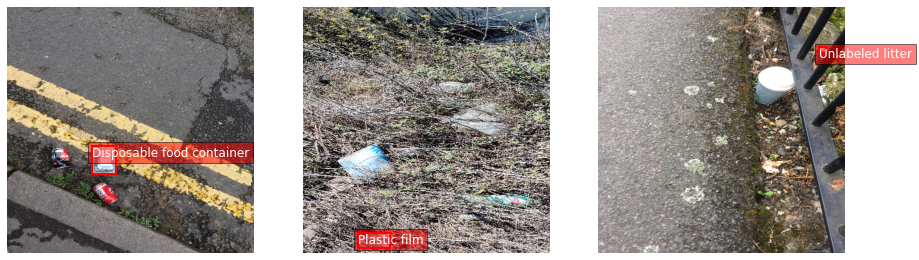

In [15]:
def show_images_with_boxes(img_list, boxes, labels, categories, num_images=3):
    # Select indices for images to display, ensuring at least one is the first image
    indices = [0]  # Ensure the first image is included
    indices += random.sample(range(1, len(img_list)), num_images - 1)  # Randomly select other images
    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))
    if num_images == 1:
        axs = [axs]  # Ensure axs is always a list
    for i, ax in zip(indices, axs):
        img = img_list[i]  # Get image
        box = boxes[i][0]  # Get bounding box
        label = labels[i][0]  # Get label
        ax.imshow(np.uint8(img * 255))  # Display image
        x = box[0] * image_size  # Calculate x-coordinate of top-left corner of bounding box
        y = box[1] * image_size  # Calculate y-coordinate of top-left corner of bounding box
        width = box[2] * image_size  # Calculate width of bounding box
        height = box[3] * image_size  # Calculate height of bounding box
        # Add rectangle patch representing the bounding box
        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        category_name = categories[label]  # Get category name from label
        # Add text annotation showing the category name
        ax.text(x, y, category_name, color='white', fontsize=12, verticalalignment='top', bbox=dict(facecolor='red', alpha=0.5))
        ax.axis('off')  # Turn off axis
    plt.show()  # Display the plot

# Create a dictionary mapping category IDs to category names
category_dict = {id: name for id, name in zip(df['category_id'], df['category'])}

# Call the function to display images with bounding boxes
show_images_with_boxes(img_list, boxes, labels, category_dict, num_images=3)

In [16]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, boxes):
        # Convert images to PyTorch tensor and permute dimensions to match PyTorch convention (N, C, H, W)
        self.images = torch.tensor(images, dtype=torch.float).permute(0, 3, 1, 2)
        # Convert labels to PyTorch tensor and squeeze to remove singleton dimensions
        self.labels = torch.tensor(labels, dtype=torch.long).squeeze()
        # Convert bounding boxes to PyTorch tensor and squeeze to remove singleton dimensions
        self.boxes = torch.tensor(boxes, dtype=torch.float).squeeze()
    
    # Define the length of the dataset (number of samples)
    def __len__(self):
        return len(self.labels)
    
    # Define how to retrieve a sample from the dataset given an index (idx)
    def __getitem__(self, idx):
        # Return the image, label, and bounding box for the given index
        return self.images[idx], self.labels[idx], self.boxes[idx]

In [17]:
# Create custom datasets for training, validation, and testing
train_dataset = CustomDataset(train_images, train_labels, train_boxes)
val_dataset = CustomDataset(val_images, val_labels, val_boxes)
test_dataset = CustomDataset(test_images, test_labels, test_boxes)


# Create data loaders for training, validation, and testing datasets
# DataLoader is responsible for managing batches during training
# shuffle=True shuffles the data at the beginning of each epoch for training
# shuffle=False disables shuffling for validation and testing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## CNN Model Architecture

In [18]:
class Network(nn.Module):
    """
    A neural network class for object detection, which includes both classification
    and bounding box prediction.
    """
    def __init__(self):
        super(Network, self).__init__()
        
        # Sequential blocks of convolutional layers with batch normalization and LeakyReLU activation
        # Each block increases the number of filters, enhancing the network's ability to capture features
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=3, padding=1),
            nn.BatchNorm2d(6),
            nn.LeakyReLU(0.1)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(6, 12, kernel_size=3, padding=1),
            nn.BatchNorm2d(12),
            nn.LeakyReLU(0.1)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(12, 24, kernel_size=3, padding=1),
            nn.BatchNorm2d(24),
            nn.LeakyReLU(0.1)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(24, 48, kernel_size=3, padding=1),
            nn.BatchNorm2d(48),
            nn.LeakyReLU(0.1)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(48, 96, kernel_size=3, padding=1),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(0.1)
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(96, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(0.1)
        )
        # Pooling layer to reduce spatial dimensions between convolutional blocks
        self.pool = nn.MaxPool2d(2, 2)
        
        # Dynamically calculating the number of features to feed into fully connected layers
        self._to_linear = None
        self.dummy_input = torch.autograd.Variable(torch.zeros(1, 3, 416, 416))
        self.convs(self.dummy_input)
        
        # Fully connected layers for classification with dropout to prevent overfitting
        self.class_fc1 = nn.Sequential(
            nn.Linear(self._to_linear, 1024),
            nn.Dropout(0.5) # Dropout with a probability of 0.5
        )
        self.class_fc2 = nn.Sequential(
            nn.Linear(1024, 256),
            nn.Dropout(0.5)
        )
        self.class_fc3 = nn.Linear(256, 64)
        self.class_out = nn.Linear(64, 61) # Output layer for classification (60 classes + background)
        
        # Fully connected layers for bounding box prediction
        self.box_fc1 = nn.Linear(self._to_linear, 1024)
        self.box_fc2 = nn.Linear(1024, 256)
        self.box_fc3 = nn.Linear(256, 64)
        self.box_out = nn.Linear(64, 4)
    def convs(self, x):
        """
        Function to pass input through convolutional blocks and pooling layers,
        also sets the _to_linear attribute for dynamic fully connected layer sizing.
        """
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(x))
        x = self.pool(self.conv3(x))
        x = self.pool(self.conv4(x))
        x = self.pool(self.conv5(x))
        x = self.pool(self.conv6(x))
        if not self._to_linear:
            self._to_linear = x.shape[1] * x.shape[2] * x.shape[3] # Calculate the flattened size
        return x
    def forward(self, x):
        """
        Forward pass through the network which includes passing the input through convolutional layers,
        flattening the output, and then passing through fully connected layers for classification
        and bounding box prediction.
        """
        x = self.convs(x)
        x = x.view(-1, self._to_linear) # Flatten the output for the fully connected layers

        # Class prediction pathway
        x_class = F.relu(self.class_fc1(x))
        x_class = F.relu(self.class_fc2(x_class))
        x_class = F.relu(self.class_fc3(x_class))
        x_class = self.class_out(x_class)
        
        # Bounding box prediction pathway
        x_box = F.relu(self.box_fc1(x))
        x_box = F.relu(self.box_fc2(x_box))
        x_box = F.relu(self.box_fc3(x_box))
        x_box = self.box_out(x_box)
        x_box = torch.sigmoid(x_box) # Apply sigmoid to ensure the outputs are between 0 and 1
        return x_class, x_box

In [19]:
# Check if CUDA (GPU) is available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the network model
model = Network()

# Move the model to the selected device (CUDA if available, otherwise CPU)
model = model.to(device)

In [20]:
def get_num_correct(preds, labels):
    # Round the predictions to the nearest integer (0 or 1) and get the index of the maximum value along dimension 1
    return torch.round(preds).argmax(dim=1).eq(labels).sum().item()

In [21]:
def get_accuracy(model, t_loader, v_loader, train=True):
    # Determine which data loader to use based on the train parameter
    data_loader = t_loader if train else v_loader
    
    correct = 0  # Initialize the number of correct predictions
    total = 0    # Initialize the total number of predictions
    
    # Iterate over batches in the selected data loader
    for imgs, labels, boxes in data_loader:
        # Move data to GPU if available
        if use_cuda and torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()
            boxes = boxes.cuda()
        
        # Forward pass through the model to get predictions
        [y_pred, z_pred] = model(imgs)
        
        # Get predicted labels by selecting the class with the highest probability
        pred = y_pred.max(1, keepdim=True)[1]
        
        # Count the number of correct predictions in the batch
        correct += pred.eq(labels.view_as(pred)).sum().item()
        
        # Increment the total number of predictions
        total += imgs.shape[0]
    
    # Calculate accuracy by dividing the total number of correct predictions by the total number of predictions
    accuracy = correct / total
    return accuracy

## Training CNN Model

In [22]:
def train(model, t_data, v_data, batch_size=64, num_epochs=30, learning_rate=0.01):
    # Set the number of worker processes for data loading
    num_workers = 0
    
    # Create data loaders for training and validation datasets
    train_loader = DataLoader(t_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    val_loader = DataLoader(v_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    
    # Define loss functions for classification and bounding box regression
    criterion = nn.CrossEntropyLoss()  # Classification loss
    criterion2 = nn.MSELoss()           # Bounding box regression loss
    
    # Define optimizer (Stochastic Gradient Descent)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    
    # Initialize lists to store training statistics
    iters, losses, train_acc, val_acc = [], [], [], []
    n = 0  # Counter for iterations
    
    # Record start time for training
    start_time = time.time()
    
    # Loop over epochs
    for epoch in range(num_epochs):
        # Loop over batches in the training dataset
        for imgs, labels, boxes in train_loader:
            # Move data to GPU if available
            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()
                boxes = boxes.cuda()
            
            # Forward pass through the model to get predictions
            [y_pred, z_pred] = model(imgs)
            
            # Calculate classification and bounding box regression losses
            loss1 = criterion(y_pred, labels)    # Classification loss
            loss2 = criterion2(z_pred, boxes)    # Bounding box regression loss
            loss = loss1 + loss2                  # Total loss
            
            # Backpropagation: Compute gradients and update weights
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            # Store training statistics
            iters.append(n)
            loss_real = float(loss) / batch_size  # Average loss per sample
            losses.append(loss_real)
            t_acc = get_accuracy(model, train_loader, val_loader, train=True)
            train_acc.append(t_acc)
            v_acc = get_accuracy(model, train_loader, val_loader, train=False)
            val_acc.append(v_acc)
            n += 1
            
            # Print training progress
            print("Epoch {}, Iter {}, Train Accuracy {:.2f}, Validation Accuracy {:.2f}, Loss {:.4f}".format(
                epoch+1, n, t_acc, v_acc, loss_real))
    
    # Record end time for training
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    # Plot training curve: Loss vs Iterations
    plt.title("Training Loss Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()
    
    # Plot training curve: Accuracy vs Iterations
    plt.title("Training Accuracy Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    
    # Print final training and validation accuracy
    print("Final Training Accuracy: {:.2f}".format(train_acc[-1]))
    print("Final Validation Accuracy: {:.2f}".format(val_acc[-1]))
    
    # Print total time elapsed for training
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

CUDA is not available.  Training on CPU ...
Epoch 1, Iter 1, Train Accuracy 0.01, Validation Accuracy 0.01, Loss 0.0660
Epoch 1, Iter 2, Train Accuracy 0.02, Validation Accuracy 0.01, Loss 0.0658
Epoch 1, Iter 3, Train Accuracy 0.01, Validation Accuracy 0.02, Loss 0.0656
Epoch 1, Iter 4, Train Accuracy 0.03, Validation Accuracy 0.01, Loss 0.0655
Epoch 1, Iter 5, Train Accuracy 0.03, Validation Accuracy 0.03, Loss 0.0652
Epoch 2, Iter 6, Train Accuracy 0.04, Validation Accuracy 0.04, Loss 0.0647
Epoch 2, Iter 7, Train Accuracy 0.06, Validation Accuracy 0.03, Loss 0.0645
Epoch 2, Iter 8, Train Accuracy 0.08, Validation Accuracy 0.07, Loss 0.0641
Epoch 2, Iter 9, Train Accuracy 0.14, Validation Accuracy 0.06, Loss 0.0641
Epoch 2, Iter 10, Train Accuracy 0.14, Validation Accuracy 0.08, Loss 0.0628
Epoch 3, Iter 11, Train Accuracy 0.15, Validation Accuracy 0.17, Loss 0.0617
Epoch 3, Iter 12, Train Accuracy 0.21, Validation Accuracy 0.16, Loss 0.0610
Epoch 3, Iter 13, Train Accuracy 0.17, Va

Epoch 22, Iter 107, Train Accuracy 0.35, Validation Accuracy 0.29, Loss 0.0376
Epoch 22, Iter 108, Train Accuracy 0.35, Validation Accuracy 0.18, Loss 0.0413
Epoch 22, Iter 109, Train Accuracy 0.32, Validation Accuracy 0.23, Loss 0.0395
Epoch 22, Iter 110, Train Accuracy 0.34, Validation Accuracy 0.28, Loss 0.0379
Epoch 23, Iter 111, Train Accuracy 0.35, Validation Accuracy 0.28, Loss 0.0342
Epoch 23, Iter 112, Train Accuracy 0.36, Validation Accuracy 0.25, Loss 0.0360
Epoch 23, Iter 113, Train Accuracy 0.33, Validation Accuracy 0.27, Loss 0.0372
Epoch 23, Iter 114, Train Accuracy 0.37, Validation Accuracy 0.31, Loss 0.0443
Epoch 23, Iter 115, Train Accuracy 0.37, Validation Accuracy 0.29, Loss 0.0350
Epoch 24, Iter 116, Train Accuracy 0.38, Validation Accuracy 0.28, Loss 0.0391
Epoch 24, Iter 117, Train Accuracy 0.33, Validation Accuracy 0.22, Loss 0.0394
Epoch 24, Iter 118, Train Accuracy 0.36, Validation Accuracy 0.25, Loss 0.0399
Epoch 24, Iter 119, Train Accuracy 0.34, Validation 

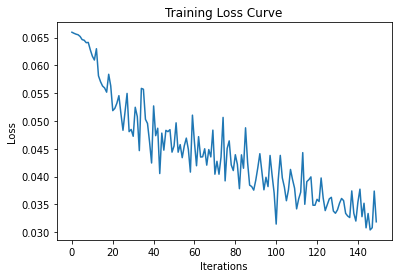

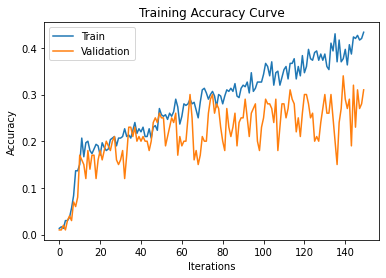

Final Training Accuracy: 0.43
Final Validation Accuracy: 0.31
Total time elapsed: 1397.24 seconds


In [23]:
# Check if CUDA (GPU) should be used
use_cuda = True

# Instantiate the main model
main_model = Network()

# If CUDA is requested and available, move the model to the GPU
if use_cuda and torch.cuda.is_available():
    main_model.cuda()
    print('CUDA is available!  Training on GPU ...')
else:
    print('CUDA is not available.  Training on CPU ...')

# Start training the main model
train(main_model, train_dataset, val_dataset, batch_size=64, num_epochs=30, learning_rate=0.01)

## Testing Model Performance

In [24]:
def evaluate_model(model, test_loader, criterion1, criterion2):
    # Set the model to evaluation mode
    model.eval()
    
    # Initialize variables to calculate accuracy and loss
    total = 0
    correct = 0
    running_loss = 0.0
    
    # Iterate over batches in the test loader
    for imgs, labels, boxes in test_loader:
        # Move data to the selected device (CUDA if available, otherwise CPU)
        imgs = imgs.to(device)
        labels = labels.to(device)
        boxes = boxes.to(device)
        
        # Forward pass through the model to get predictions
        outputs, pred_boxes = model(imgs)
        
        # Calculate classification and bounding box regression losses
        loss1 = criterion1(outputs, labels)    # Classification loss
        loss2 = criterion2(pred_boxes, boxes)  # Bounding box regression loss
        total_loss = loss1 + loss2              # Total loss
        
        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Accumulate running loss
        running_loss += total_loss.item()
    
    # Calculate accuracy and average loss
    accuracy = 100 * correct / total
    average_loss = running_loss / len(test_loader)
    
    return accuracy, average_loss

# Define loss functions for classification and bounding box regression
criterion1 = nn.CrossEntropyLoss()
criterion2 = nn.MSELoss()

# Evaluate the main model on the test set
test_accuracy, test_loss = evaluate_model(main_model, test_loader, criterion1, criterion2)

# Print the test accuracy and test loss
print('Test Accuracy: {:.2f}%'.format(test_accuracy))
print('Test Loss: {:.2f}'.format(test_loss))

Test Accuracy: 29.00%
Test Loss: 3.61


## Visualizing Predictions

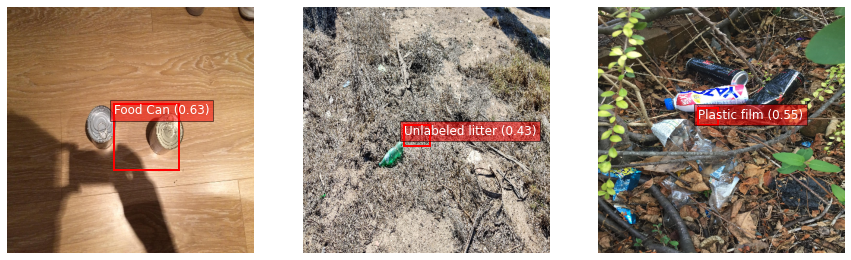

In [28]:
def visualize_predictions(test_loader, model, categories, num_images=3):
    # Set the model to evaluation mode
    model.eval()
    
    # Initialize lists to store images, predicted boxes, predicted labels, and confidences
    images, pred_boxes, pred_labels, confidences = [], [], [], []
    
    # Get the total number of samples in the test loader
    total_samples = len(test_loader.dataset)
    
    # Select random indices for visualization
    random_indices = random.sample(range(total_samples), num_images)
    
    # Initialize index counter
    idx_count = 0
    
    # Iterate over batches in the test loader
    for imgs, labels, boxes in test_loader:
        # Iterate over individual images in the batch
        for img, label, box in zip(imgs, labels, boxes):
            # Check if the current index is among the randomly selected indices for visualization
            if idx_count in random_indices:
                # Move image to the selected device
                img = img.to(device)
                
                # Perform forward pass through the model to get predictions
                output, bbox_output = model(img.unsqueeze(0))
                
                # Calculate class probabilities and predicted label
                probabilities = torch.softmax(output, dim=1)
                confidence, predicted_label = torch.max(probabilities, 1)
                
                # Get predicted box and confidence
                predicted_box = bbox_output.squeeze(0).detach()
                
                # Append image, predicted box, predicted label, and confidence to respective lists
                images.append(img.cpu().numpy())
                pred_labels.append(predicted_label.cpu().item())
                pred_boxes.append(predicted_box.cpu().numpy())
                confidences.append(confidence.cpu().item())
            
            # Increment index counter
            idx_count += 1
            
            # Check if the desired number of images has been visualized
            if len(images) >= num_images:
                break
        
        # Check if the desired number of images has been visualized
        if len(images) >= num_images:
            break
    
    # Create subplots for visualizing images with predicted boxes and labels
    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))
    
    # Iterate over images and corresponding predicted boxes and labels
    for i, ax in enumerate(axs):
        # Convert image from tensor to NumPy array and transpose dimensions
        img = images[i].transpose(1, 2, 0)
        
        # Convert pixel values to uint8
        img = (img * 255).astype(np.uint8)
        
        # Display image
        ax.imshow(img)
        
        # Get predicted box and label for the current image
        box = pred_boxes[i] * image_size
        label_id = pred_labels[i]
        
        # Get category name corresponding to the predicted label
        label = categories.get(label_id, 'Unknown')
        
        # Format confidence text
        confidence_text = f"{label} ({confidences[i]:.2f})"
        
        # Add rectangle patch representing the predicted box
        rect = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        
        # Add confidence text
        ax.text(box[0], box[1], confidence_text, color='white', fontsize=12, verticalalignment='top', bbox=dict(facecolor='red', alpha=0.5))
        
        # Turn off axis
        ax.axis('off')
    
    # Show the plot
    plt.show()

# Create a dictionary mapping category IDs to category names
category_dict = {id: name for id, name in zip(df['category_id'], df['category'])}

# Visualize predictions on the test set
visualize_predictions(test_loader, main_model, category_dict, num_images=3)

## Conclusion:
The model demonstrates an ability to learn from data, as evidenced by increasing accuracies and decreasing loss. However, achieving only around 30-40% accuracy indicates that the model has limited predictive power. Improvements could include more data, data augmentation, hyperparameter tuning, regularization strategies to combat overfitting, or a more complex model architecture. Additionally, if possible, utilizing a GPU would significantly decrease training time and might allow for more complex models to be trained.